# How to compare curvilnear and regular grid netcdf? 

In [144]:
import numpy as np 
import os 
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
#pip install progressbar
import progressbar

In [222]:
# data path:
# just used the sellonlatbox,43,89,39,57 -selyear,1979/1980 
# The cdo codes used: 
# cdo -O  -sellonlatbox,43,89,39,57 -selyear,1979/1980 tas_CAS-22_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_RMIB-UGent-ALARO-0_v1_day_19770101-19801231.nc tas_anas_box.nc
# cdo -sellonlatbox,43,89,39,57 tas_W5E5v2.0_19790101-19801231.nc tas_W5E5v2.0_19790101-19801231_box.nc

obs   = "tas_W5E5v2.0_19790101-19801231_box.nc"
model = "tas_anas_box.nc"


In [223]:
# read the model data: 
nc = NetCDFFile(model)
lats = nc.variables['lat'][:]
lons = nc.variables['lon'][:]
rlat = nc.variables['x'][:]
rlon = nc.variables['y'][:]
tas_model = nc.variables['tas'][:]
nc.close()
# read the obs data : 
nc =  NetCDFFile(obs)
lats_obs = nc.variables['lat'][:]
lons_obs = nc.variables['lon'][:]
lon_obs, lat_obs = np.meshgrid(lons_obs, lats_obs)
tas_obs = nc.variables['tas'][:]


In [224]:
print(tas_obs.shape, tas_model.shape)
# the model starts one day later!

(731, 36, 92) (731, 96, 157)


### Plot the 2 grids (model in red and obs in black)

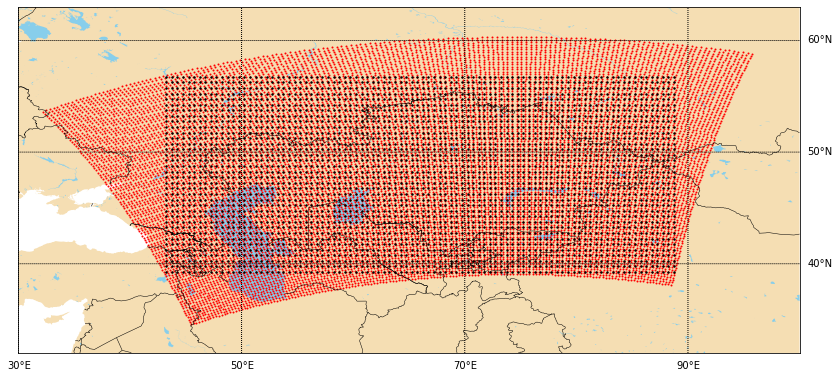

In [247]:
# plot the grids : 
fig = plt.figure('1')
fig.set_size_inches(14, 10)
my_map = Basemap(projection='cyl', 
                 llcrnrlat=32, llcrnrlon=30,
                 urcrnrlat=63, urcrnrlon=100,
                 resolution='i', area_thresh=1.0)

my_map.fillcontinents(color='wheat', lake_color='skyblue', zorder=-1)
my_map.drawcountries()
lons_m, lats_m = my_map(lons, lats)
my_map.scatter(lons_m, lats_m ,s=1, color='red', zorder=1, alpha=1)
lon_obs_m, lat_obs_m = my_map(lon_obs, lat_obs)
my_map.scatter(lon_obs_m, lat_obs_m ,s=2, color='k', alpha=1)
parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
my_map.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
my_map.drawmeridians(meridians,labels=[True,False,False,True])
plt.savefig("grids.png", bbox_inches = 'tight',
    pad_inches = 0);


## Let's interpolate the model data on observation: 


In [246]:
# Interpolatatonmethods :
methods = ['nearest', 'linear','cubic']
# initialize the data:
model_remaped = np.zeros(tas_obs.shape) + np.float('nan')
# remap in a loop:
#   add some progress bar!
bar = progressbar.ProgressBar(maxval=731, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for day in range(model_remaped.shape[0]):
    bar.update(day+1)
    model_remaped[day,:,:] = griddata((lats.reshape(-1),lons.reshape(-1)), 
                                      tas_model[day,:,:].squeeze().reshape(-1),
                                      (lat_obs,lon_obs), method=methods[0])
bar.finish()


[========================================================================] 100%


## Calculate the Absolute Error for whole the period:
   > MODEL minus OBS

<ipython-input-261-9801e0acb3a2>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  my_map.pcolor(lon_obs,lat_obs,


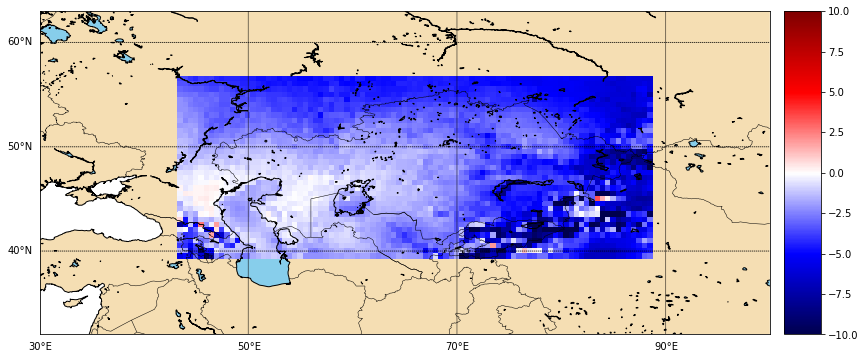

In [261]:
error = model_remaped-tas_obs

# plot the mean error:

fig = plt.figure('1')
fig.set_size_inches(14, 10)
my_map = Basemap(projection='cyl', 
                 llcrnrlat=32, llcrnrlon=30,
                 urcrnrlat=63, urcrnrlon=100,
                 resolution='i', area_thresh=1.0)

my_map.fillcontinents(color='wheat', lake_color='skyblue', zorder=-1)
my_map.drawcoastlines()
my_map.drawcountries()
lon_obs_m, lat_obs_m = my_map(lon_obs, lat_obs)
# plot the means: 

my_map.pcolor(lon_obs,lat_obs,
           error[:,:,:].mean(axis=0),
           vmin=-10, vmax=10, cmap='seismic' )
my_map.colorbar()
parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
my_map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(10.,351.,20.)
my_map.drawmeridians(meridians,labels=[True,False,False,True])
plt.savefig("error.png", bbox_inches = 'tight',
    pad_inches = 0);